# ガウス分布を利用したレート予想
---





**ライブラリ**  
scipy.statsは確率計算用のライブラリ、なくてもいい


In [4]:
pip install mplfinance

     |████████████████████████████████| 62 kB 790 kB/s 


In [5]:
import pandas as pd    
import numpy as np      
import matplotlib.pyplot as plt     
import mplfinance as mpf    
#from scipy.stats import norm

**マウント&データ読み込み**

In [7]:
!echo "Google Driveをマウントします"
from google.colab import drive 
drive.mount('/content/drive')
fx = pd.read_csv("/content/drive/MyDrive/fx/fx-daily.csv",index_col=0,parse_dates=True) 

Google Driveをマウントします
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**変動計算**

In [8]:
fx['fluctuation']=10*(fx.High-fx.Low)   #変動でかい→異常事態→取引ストップ
fx['criterion']=10

**標準偏差、ガウス分布、評価**
ざっくりアルゴリズム


1.   元データは100行配列
2.   [0,0,0.......,0]という0×100の行列を用意、グラフ化する  

1.   カウンターiを１つずつ増やして色々計算





In [18]:
i=0
num=0
count=0
subcount=0
a=[0]*100
b=[0]*100
c=[0]*100
d=[0]*100
while i<95:     
    a[i+5]=fx.Open[i:i+5].std()  
    tmp=[]        #ループごとに配列を初期化する
    tmp.extend(fx.Open[i:i+5]), tmp.extend(fx.Close[i:i+5]), tmp.extend(fx.High[i:i+5]), tmp.extend(fx.Low[i:i+5])  
                #標準偏差用に配列cにデータを追加しまくる
    tmp_mean=np.mean(tmp)   #配列cの平均値
    tmp_std=np.std(tmp)     #配列cの標準偏差
    #b[i+5]=100*norm.pdf(fx.Open[i+5],tmp_mean,tmp_std)    
                #1つ目の引数が発生する確率を返す関数、この値をb[]に入れていく
    up_rate=np.exp(-(fx.Close[i+5]+0.3-tmp_mean)**2/2*tmp_std**2)/np.sqrt(2*tmp_std**2*np.pi)   #上昇する確率
    down_rate=np.exp(-(fx.Close[i+5]-0.3-tmp_mean)**2/2*tmp_std**2)/np.sqrt(2*tmp_std**2*np.pi) #下降する確率
    base_rate=np.exp(-(fx.Close[i+5]-tmp_mean)**2/2*tmp_std**2)/np.sqrt(2*tmp_std**2*np.pi)     #継続する確率
    if base_rate<up_rate:
        b[i+5]=100*(up_rate-base_rate)     
    if base_rate<down_rate:
        c[i+5]=-100*(down_rate-base_rate)
    d[i+5]=b[i+5]+c[i+5]

    #実際に有用な指標か確率判定
    if d[i+5]>2.0 and i<93:
        num+=1
        if fx.Low[i+6]<fx.Close[i+5]+0.3 and fx.Close[i+5]+0.3<fx.High[i+3]:
            count+=1
            subcount+=1
        elif fx.Low[i+7]<fx.Close[i+5]+0.3 and fx.Close[i+7]+0.3<fx.High[i+3]:
            subcount+=1
    if d[i+5]<-2.0 and i<93:
        num+=1
        if fx.Low[i+6]<fx.Close[i+5]-0.3 and fx.Close[i+5]-0.3<fx.High[i+3]:
            count+=1
            subcount+=1
        elif fx.Low[i+7]<fx.Close[i+5]-0.3 and fx.Close[i+7]-0.3<fx.High[i+3]:
            subcount+=1
    i+=1


**プロット用に色々作る**

In [19]:
fx['bollinger_up2']=fx.Open+a+a
fx['bollinger_down2']=fx.Open-a-a
fx['bollinger_up3']=fx.Open+a+a+a
fx['bollinger_down3']=fx.Open-a-a-a
fx['next_up_%']=b
fx['next_down_%']=c
fx['nextrate']=d

**メインパネルプロット**

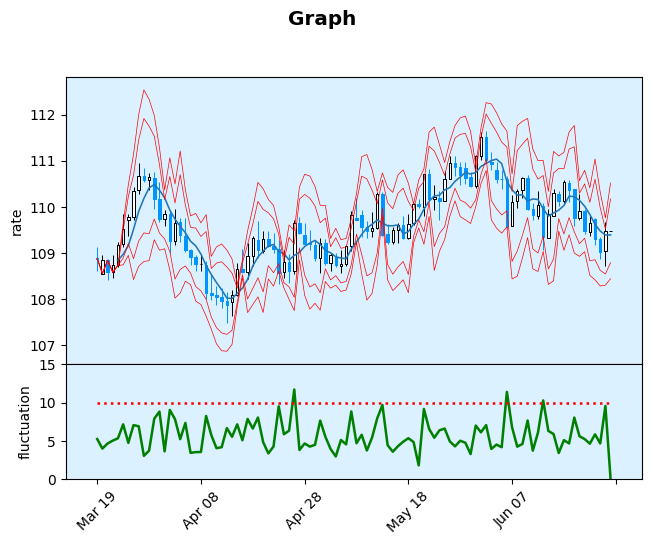

In [20]:
add_plot = [mpf.make_addplot(fx['fluctuation'], color='green', ylabel='fluctuation', ylim=(0,15),panel=1),
            mpf.make_addplot(fx['criterion'], color='red', linestyle='dotted', panel=1),
            mpf.make_addplot(fx['bollinger_up2'], color='red', width=0.5, panel=0),
            mpf.make_addplot(fx['bollinger_down2'], color='red', width=0.5, panel=0),
            mpf.make_addplot(fx['bollinger_up3'], color='red', width=0.5, panel=0),
            mpf.make_addplot(fx['bollinger_down3'], color='red', width=0.5, panel=0),
            ]
mpf.plot(fx, type='candle', ylabel='rate', addplot=add_plot, main_panel=0, mav=(5), style='blueskies', title='Graph')

**セカンドパネルプロット**

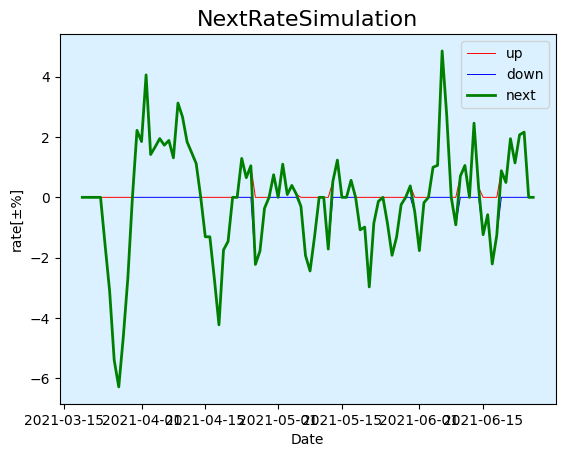

In [21]:
fig, ax = plt.subplots()
ax.plot(fx.index, fx['next_up_%'], color='red', linewidth=0.7, label='up',)
ax.plot(fx.index, fx['next_down_%'], color='blue', linewidth=0.7, label='down')
ax.plot(fx.index, fx['nextrate'], color='green', linewidth=2, label='next')
#ax.plot(fx.index, fx['0'] , color='black')
ax.set_xlabel('Date')
ax.set_ylabel('rate[±%]')
ax.set_title('NextRateSimulation',fontsize=16)
ax.legend() 
plt.show()

**確率表示**

In [22]:
ans1=100*count/num
ans2=100*subcount/num
print("num,count,subcount = "+str(num)+","+str(count)+","+str(subcount)+"\n1日後の正答率は"+str(ans1)+" : 2日後の正答率は"+str(ans2))

num,count,subcount = 20,12,15
1日後の正答率は60.0 : 2日後の正答率は75.0
